In [1]:
import glob, matplotlib, pandas, argparse
import numpy as np
# The following package is used to scan through different values of k and find the optimal value using the gap
# and gap* statistic. More info here https://github.com/milesgranger/gap_statistic
from gap_statistic import OptimalK
from kmeanstf import KMeansTF
#km = KMeansTF.self_test()
from kmeans_pytorch import kmeans as KMeansPT
from sklearn_extra.cluster import KMedoids
# Beautification of plot utilities
from plotParams import varLabels, binnings, units
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, OPTICS
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

randomState = 5
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [2]:
from data_ttMET_delphes import get_DataLoaders
args = argparse.Namespace()
args.data = '/users/whopkins/sigclustering/sigclustering/python/ttMET_delphes_sepSigs.h5'
args.time_throughput = False
args.batch_size = 128

def quantScaler(data, args):
    scaler = MinMaxScaler((args['minScale'], args['maxScale']))
    mask = data < args['nanEq']
    data[mask] = -1.*(args['maxScale']-args['minScale'])/args['nBins']
    data[~mask] = scaler.fit_transform(data[~mask].reshape(-1, 1)).flatten()
    
    transformer = QuantileTransformer(n_quantiles=10)
    data[~mask] = transformer.fit_transform(data[~mask].reshape(-1, 1)).flatten()
    return data

In [3]:
loadBranches = ['MET', 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good', 'num_bjets', 'm_1jet']
signals = []#'sig_1300_1', 'sig_700_400']#, 'sig_800_1' , 'sig_800_500']
trainDataLoader, testDataLoader, allData, scaledData, selectedSigs, reducedData = get_DataLoaders(args, loadBranches, signals=signals, minSize=1000, reduceData=True)#, scaler=quantScaler)
print(allData.keys())

No preselection specified


Number of signal samples: 298


Dropping sig_200_1 with size 234
Dropping sig_200_100 with size 468


Dropping sig_200_50 with size 309
Dropping sig_250_1 with size 602


Dropping sig_250_100 with size 594
Dropping sig_250_150 with size 852


Dropping sig_250_50 with size 498


Dropping sig_300_100 with size 945


Total number of events to be clustered: 7326697


We will make all samples have the following raw event yield: 1131


aeData.shape: (327990, 9)
aeData.columns: Index(['MET', 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good',
       'num_bjets', 'm_1jet'],
      dtype='object')
tempWeights.shape: (327990, 91)
samples: ['sig_1000_1', 'sig_1000_100', 'sig_1000_150', 'sig_1000_200', 'sig_1000_250', 'sig_1000_300', 'sig_1000_350', 'sig_1000_400', 'sig_1000_450', 'sig_1000_50', 'sig_1000_500', 'sig_1000_550', 'sig_1000_600', 'sig_1000_650', 'sig_1050_1', 'sig_1050_100', 'sig_1050_150', 'sig_1050_200', 'sig_1050_250', 'sig_1050_300', 'sig_1050_350', 'sig_1050_400', 'sig_1050_450', 'sig_1050_50', 'sig_1050_500', 'sig_1050_550', 'sig_1050_600', 'sig_1050_650', 'sig_1100_1', 'sig_1100_100', 'sig_1100_150', 'sig_1100_200', 'sig_1100_250', 'sig_1100_300', 'sig_1100_350', 'sig_1100_400', 'sig_1100_450', 'sig_1100_50', 'sig_1100_500', 'sig_1100_550', 'sig_1100_600', 'sig_1100_650', 'sig_1150_1', 'sig_1150_100', 'sig_1150_150', 'sig_1150_200', 'sig_1150_250', 'sig_1150_300', 'sig_1150_350', 'sig_1150_400',

Index(['nj_good', 'num_bjets', 'pT_1jet', 'eta_1jet', 'phi_1jet', 'm_1jet',
       'pT_2jet', 'eta_2jet', 'phi_2jet', 'm_2jet', 'pT_3jet', 'eta_3jet',
       'phi_3jet', 'm_3jet', 'pT_4jet', 'eta_4jet', 'phi_4jet', 'm_4jet',
       'pT_5jet', 'eta_5jet', 'phi_5jet', 'm_5jet', 'pT_6jet', 'eta_6jet',
       'phi_6jet', 'm_6jet', 'pT_7jet', 'eta_7jet', 'phi_7jet', 'm_7jet',
       'pT_8jet', 'eta_8jet', 'phi_8jet', 'm_8jet', 'pT_9jet', 'eta_9jet',
       'phi_9jet', 'm_9jet', 'pT_10jet', 'eta_10jet', 'phi_10jet', 'm_10jet',
       'pT_1bjet', 'eta_1bjet', 'phi_1bjet', 'm_1bjet', 'pT_2bjet',
       'eta_2bjet', 'phi_2bjet', 'm_2bjet', 'pT_3bjet', 'eta_3bjet',
       'phi_3bjet', 'm_3bjet', 'pT_4bjet', 'eta_4bjet', 'phi_4bjet', 'm_4bjet',
       'pT_5bjet', 'eta_5bjet', 'phi_5bjet', 'm_5bjet', 'pT_6bjet',
       'eta_6bjet', 'phi_6bjet', 'm_6bjet', 'pT_7bjet', 'eta_7bjet',
       'phi_7bjet', 'm_7bjet', 'pT_8bjet', 'eta_8bjet', 'phi_8bjet', 'm_8bjet',
       'pT_9bjet', 'eta_9bjet', 'phi_9b

In [4]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer

newColumns=[loadBranch for loadBranch in loadBranches]
newColumns.append('sampName')
myScaledData = selectedSigs[newColumns].copy(deep=True)
scalers = {}
minScale = 0
maxScale = 1
nBins = 20
nanEq = -90
for column in loadBranches:
    scaler = QuantileTransformer()
    minMaxScaler = MinMaxScaler([minScale, maxScale])
    mask = myScaledData[column] < nanEq
    myScaledData.loc[mask, column] = -1.*(maxScale-minScale)/nBins
    myScaledData.loc[~mask, column] = scaler.fit_transform(myScaledData.loc[~mask, [column]].to_numpy())
    

print(reducedData.shape)
print(scaledData.shape)
print(scaledData['num_bjets'])

(290, 10)
(327990, 10)
17884    0.333333
32189    0.000000
18463    0.500000
2049     0.333333
15630    0.333333
           ...   
12057    0.333333
1876     0.333333
2966     0.333333
3655     0.166667
11764    0.166667
Name: num_bjets, Length: 327990, dtype: float64


In [5]:
# Needed to define my own clusterer to add the weights when using OptimalK. Not needed when using KMeans from scikit-learn directly.
def clusterer(X: np.ndarray, k: int, weights: np.ndarray, random_state: int):
    """
    Function to wrap a sklearn model as a clusterer for OptimalK
    First two arguments are always the data matrix, and k. 
    Third argument are sample weights so that we can weight background correctly.
    """
    #m = MiniBatchKMeans(n_clusters=k, random_state=random_state)
    m = KMedoids(n_clusters=k, random_state=random_state)
    #m = KMeans(n_clusters=k, random_state=random_state)
    #m.fit(X, sample_weight=weights)
    m.fit(X)
    #return m.cluster_centers_, m.predict(X, sample_weight=weights)
    return m.cluster_centers_, m.predict(X)

#cDataWithName = myScaledData
cDataWithName = scaledData
#print(scaledData)
doAvg = False
sumStr = ''
if doAvg:
    cDataWithName = reducedData
    sumStr = '_avg'
print(cDataWithName.shape)
trainBranches = ['MET', 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good']#, 'num_bjets']
varListStr = '_'.join(trainBranches)
clusteringData = cDataWithName[trainBranches].copy(deep=True)
k_max=20
optimalK = OptimalK(n_jobs=1, clusterer=clusterer, clusterer_kwargs={"random_state":randomState, 'weights':np.ones(cDataWithName.shape[0])})
n_clusters = optimalK(clusteringData.to_numpy(), cluster_array=np.arange(1, k_max+1))

(327990, 10)


MemoryError: Unable to allocate 802. GiB for an array with shape (327990, 327990) and data type float64

In [6]:

bestK = -1;
for diffI in range(optimalK.gap_df['diff'].shape[0]):
    if optimalK.gap_df['diff'][diffI] > 0 and diffI+1 > 1:
        bestK = diffI+1;
        break;
print(bestK)
# Find the optimal K
fig, ax = plt.subplots()
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap_value'], yerr=optimalK.gap_df['sk'], fmt='-o')
plt.ylabel('gap')
plt.xlabel('k')
plt.savefig(f"gap_{varListStr}{sumStr}.svg",bbox_inches='tight')
plt.savefig(f"gap_{varListStr}{sumStr}.pdf",bbox_inches='tight')
fig, ax = plt.subplots()
plt.plot(range(1, k_max+1), optimalK.gap_df['diff'], '-o')
plt.ylabel('gap$_{k}$-(gap$_{k+1}$+$\sigma$(gap$_{k+1}$))')
plt.xlabel('k')
ax.text(0.65, 0.2, f'Optimal $k$ ={bestK}', transform=ax.transAxes)#, fontsize=font)
plt.savefig(f"diff_{varListStr}{sumStr}.svg",bbox_inches='tight')
plt.savefig(f"diff_{varListStr}{sumStr}.pdf",bbox_inches='tight')
# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0


TypeError: 'NoneType' object is not subscriptable

TypeError: 'NoneType' object is not subscriptable

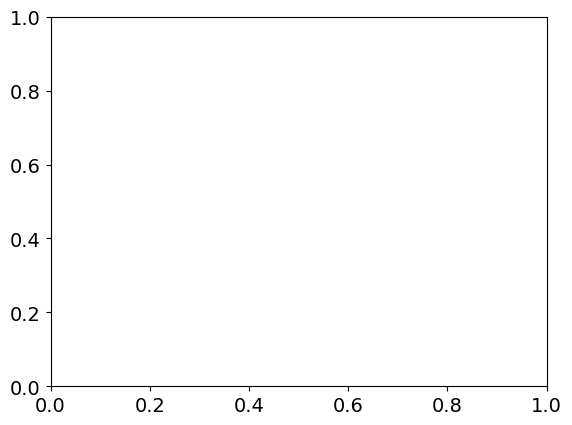

TypeError: 'NoneType' object is not subscriptable

In [7]:
# Repeat for gap*. The outcome is not expected to be consistent but it's interesting to see alternatives.
fig, ax = plt.subplots()
# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0
bestKStar = np.argmax(optimalK.gap_df['gap*'])+1
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap*'], fmt='-o')
plt.ylabel('gap*')
plt.xlabel('k')
ax.text(0.65, 0.2, f'Optimal $k$ ={bestK}', transform=ax.transAxes)#, fontsize=font)
plt.savefig(f"gapstar_{varListStr}{sumStr}.svg",bbox_inches='tight')
plt.savefig(f"gapstar_{varListStr}{sumStr}.pdf",bbox_inches='tight')
# The gap statistics overestimates the number of clusters when there are many clusters.
#if bestK >=10 and bestKStar>1:
#    bestK = bestKStar

In [8]:
# Get the centroids and lables.
bestNClus = 3
Kmean = MiniBatchKMeans(n_clusters=bestNClus, random_state=randomState)
Kmean.fit(clusteringData.to_numpy())
centroids = Kmean.cluster_centers_
clusLabels = Kmean.labels_
#print(centroids)

In [9]:
sampNames = selectedSigs.sampName.unique()
stopLSPMasses = {}
for sampLabel in sampNames:
    dummy, stopMass, lspMass = sampLabel.split("_")[:3]
    stopMass = int(stopMass)
    lspMass = int(lspMass)
    stopLSPMasses[sampLabel] = (stopMass, lspMass)
    
stopMasses = []
lspMasses = []
# Clusters that contain the highest fraction of a signal are considered the best cluster.
bestClusters = {}
bestClusFracs = {}
for sampLabel in sorted(sampNames):
    stopMass = stopLSPMasses[sampLabel][0]
    lspMass = stopLSPMasses[sampLabel][1]
    stopMasses.append(stopMass)
    lspMasses.append(lspMass)
    frac = -99
    bestClus = -1
    for clusI in range(bestNClus):
        sampIndex = (cDataWithName.sampName==sampLabel)
        sampClusIndex = (sampIndex) & (clusLabels==clusI)
        clusFrac = 1.*sum(sampClusIndex)/sum(sampIndex)
        if clusFrac > frac:
            frac = clusFrac
            bestClus = clusI
    bestClusters[(stopMass,lspMass)] = bestClus
    bestClusFracs[(stopMass, lspMass)] = frac

3


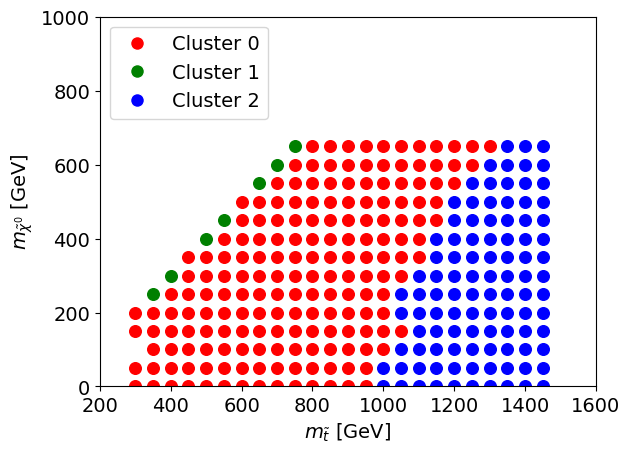

In [17]:
colors = ['r', 'g', 'b', 'y', 'c', 'k', 'm', 'tab:orange', 'tab:brown', 'olive', 'tab:purple', 'tab:pink', 'tab:blue']
fig, ax = plt.subplots()
bestClusIndex = sorted(list(set(bestClusters.values())))
print(len(bestClusIndex))
bestClusLabels=[f'Cluster {clusI}' for clusI in bestClusIndex]
colorDict = {}
for stopLSPMass in bestClusters:
    plt.scatter(stopLSPMass[0], stopLSPMass[1], c=colors[bestClusters[stopLSPMass]], label=f'Cluster {bestClusters[stopLSPMass]}', alpha=1, s=70)
    colorDict[bestClusters[stopLSPMass]] = colors[bestClusters[stopLSPMass]]
    #ax.annotate(f'{round(bestClusFracs[stopLSPMass]*100)}%', stopLSPMass, fontsize=6)

ax.set_xlabel("$m_{\\tilde{t}}$ [GeV]")
ax.set_ylabel("$m_{\\tilde{\chi}^0}$ [GeV]")
ax.set_xlim(200,1600)
ax.set_ylim(0,1000)
legHandles = [matplotlib.lines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=colorDict[clusI], markersize=10) for clusI in bestClusIndex]
plt.legend(ncol=1, handles=legHandles, labels=bestClusLabels, loc='upper left')
plt.savefig(f"grid_postclustering_k{bestNClus}_{varListStr}{sumStr}_gap.svg",bbox_inches='tight')
plt.savefig(f"grid_postclustering_k{bestNClus}_{varListStr}{sumStr}_gap.pdf",bbox_inches='tight')

In [18]:
errors = []
refPoints = []
for clusI in range(bestNClus):
    errors.append([])
    refPoints.append([])
    indivClusData = cDataWithName[clusLabels==clusI]
    tempList = []
    for varI, trainVar in enumerate(trainBranches):
        ref = np.median(indivClusData[trainVar])
        lowErr = ref-np.quantile(indivClusData[trainVar], 0.16)
        highErr = np.quantile(indivClusData[trainVar], 0.84)-ref
        refPoints[clusI].append(ref)
        tempList.append([lowErr, highErr])
    errors[clusI] = np.swapaxes(np.array(tempList), 0, 1)
errors = np.array(errors)
refPoints = np.array(refPoints)



3


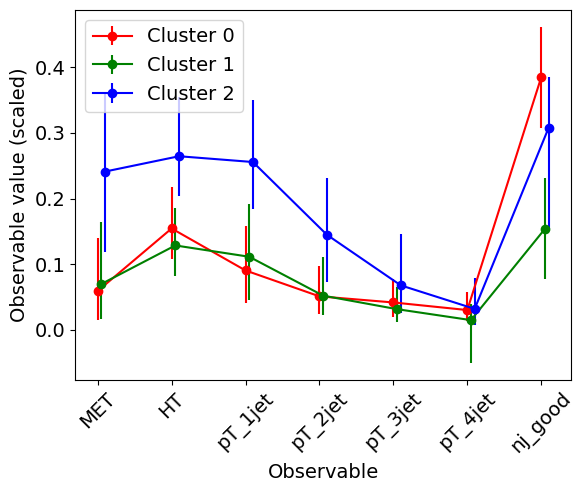

In [21]:
colors = ['r', 'g', 'b', 'y', 'c', 'k', 'm', 'tab:orange', 'tab:brown', 'olive', 'tab:purple', 'tab:pink', 'tab:blue']
markers = ["o", "^", "<", ">", "s", "D", "x", "P"]
fig, ax = plt.subplots()
bestClusIndex = sorted(list(set(bestClusters.values())))
print(len(bestClusIndex))
bestClusLabels=[f'Cluster {clusI}' for clusI in bestClusIndex]

for cI in range(bestNClus):
    plt.errorbar(np.arange(len(trainBranches))+0.05*cI, refPoints[cI], yerr=errors[cI], label=f'Cluster {cI}', marker='o', color=colorDict[cI])#, alpha=1, s=70)

ax.set_xlabel("Observable")
ax.set_ylabel("Observable value (scaled)")
#ax.set_xlim(200,1600)
#ax.set_ylim(0,1000)
ax.set_xticks([i for i in range(len(trainBranches))])
ax.set_xticklabels(trainBranches, rotation=45)
ax.legend()
plt.savefig(f"obs_cms_style_ttMET_postclustering_k{bestNClus}_{varListStr}{sumStr}_gap.svg",bbox_inches='tight')
plt.savefig(f"obs_cms_style_ttMET_postclustering_k{bestNClus}_{varListStr}{sumStr}_gap.pdf",bbox_inches='tight')